# **Thành Viên**
## **Đỗ Minh Khôi - 21521007**
## **Trương Hồ Phước Thiện - 21522629**

# MÔ TẢ BÀI TOÁN

- Input: Chữ số viết tay
- Output: Kết quả nhận dạng

Tham khảo: https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-from-scratch-for-mnist-handwritten-digit-classification/

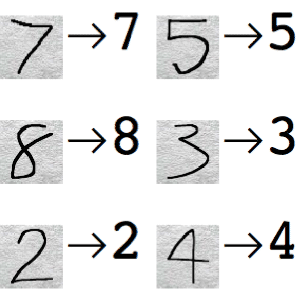

# MNIST Handwritten Digit Classification Dataset

- Các ảnh greyscale có kích thước 28x28

In [160]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import os
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


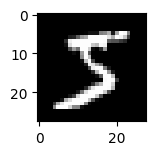

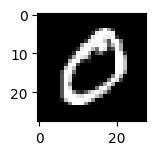

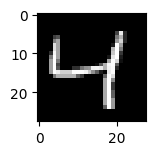

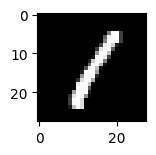

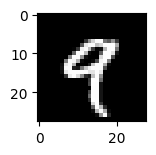

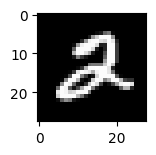

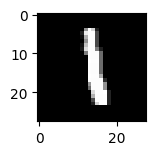

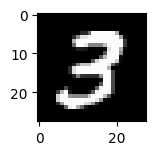

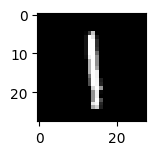

In [161]:
from tensorflow.keras.datasets import mnist
from matplotlib import pyplot as plt

# load dataset
(trainX, trainy), (testX, testy) = mnist.load_data()

# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))

# plot first few images
for i in range(9):
  # define subplot
  plt.subplot(330 + 1 + i)
  # plot raw pixel data
  plt.imshow(trainX[i], cmap=plt.get_cmap('gray'))
  # show the figure
  plt.show()

In [162]:
from numpy import mean
from numpy import std
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import SGD
from numpy import argmax
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model

## Load Dataset

- we know that the images are all pre-aligned (e.g. each image only contains a hand-drawn digit), that the images all have the same square size of 28×28 pixels, and that the images are grayscale. Therefore, we can load the images and reshape the data arrays to have a single color channel.
- a one hot encoding for the class element of each sample, transforming the integer into a 10 element binary vector with a 1 for the index of the class value, and 0 values for all other classes

In [163]:
def load_dataset():
  # load dataset
  (trainX, trainY), (testX, testY) = mnist.load_data()
  trainX_set = []
  for i in trainX:
    tmp = cv2.resize(i, (50, 50))
    trainX_set.append(tmp)

  testX_set = []
  for i in testX:
    tmp = cv2.resize(i, (50, 50))
    testX_set.append(tmp)
  trainX = np.array(trainX_set)
  testX = np.array(testX_set)
  # reshape dataset to have a single channel
  trainX = trainX.reshape((trainX.shape[0], 50, 50, 1))
  testX = testX.reshape((testX.shape[0], 50, 50, 1))

  # one hot encode target values
  trainY = to_categorical(trainY)
  testY = to_categorical(testY)
  return trainX, trainY, testX, testY

## Prepare Pixel Data

- We know that the pixel values for each image in the dataset are unsigned integers in the range between black and white, or 0 and 255.

- We do not know the best way to scale the pixel values for modeling, but we know that some scaling will be required.

- A good starting point is to normalize the pixel values of grayscale images, e.g. rescale them to the range [0,1]. This involves first converting the data type from unsigned integers to floats, then dividing the pixel values by the maximum value.

In [164]:
def prep_pixels(train, test):
  # convert from integers to floats
  train_norm = train.astype('float32')
  test_norm = test.astype('float32')

  # normalize to range 0-1
  train_norm = train_norm / 255.0
  test_norm = test_norm / 255.0

  # return normalized images
  return train_norm, test_norm

## Define Model



In [165]:
def define_model():
  model = Sequential()
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(50, 50, 1)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.2))
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.2))
  model.add(Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.2))
  model.add(Flatten())
  model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(10, activation='softmax'))

  # compile model
  opt = SGD(learning_rate=0.01, momentum=0.9)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

  return model

## Evaluate Model

In [166]:
# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
  scores, histories = list(), list()

  # prepare cross validation
  kfold = KFold(n_folds, shuffle=True, random_state=1)

  # enumerate splits
  for train_ix, test_ix in kfold.split(dataX):

    # define model
    model = define_model()

    # select rows for train and test
    trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]

    # fit model
    history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)

    # evaluate model
    _, acc = model.evaluate(testX, testY, verbose=0)
    print('> %.3f' % (acc * 100.0))

    # stores scores
    scores.append(acc)
    histories.append(history)

  return scores, histories

## Present Results

In [167]:
def summarize_diagnostics(histories):
  for i in range(len(histories)):
    # plot loss
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(histories[i].history['loss'], color='blue', label='train')
    plt.plot(histories[i].history['val_loss'], color='orange', label='test')

    # plot accuracy
    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(histories[i].history['accuracy'], color='blue', label='train')
    plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
    plt.show()

In [168]:
def summarize_performance(scores):
  # print summary
  print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))

  # box and whisker plots of results
  plt.boxplot(scores)
  plt.show()

In [169]:
def run_test_harness():
  # load dataset
  trainX, trainY, testX, testY = load_dataset()

  # prepare pixel data
  trainX, testX = prep_pixels(trainX, testX)

  # evaluate model
  scores, histories = evaluate_model(trainX, trainY)

  # learning curves
  summarize_diagnostics(histories)

  # summarize estimated performance
  summarize_performance(scores)

> 99.025
> 98.900
> 99.008
> 99.042
> 99.000


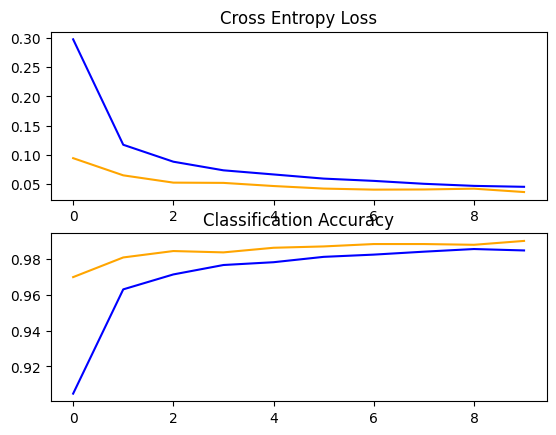

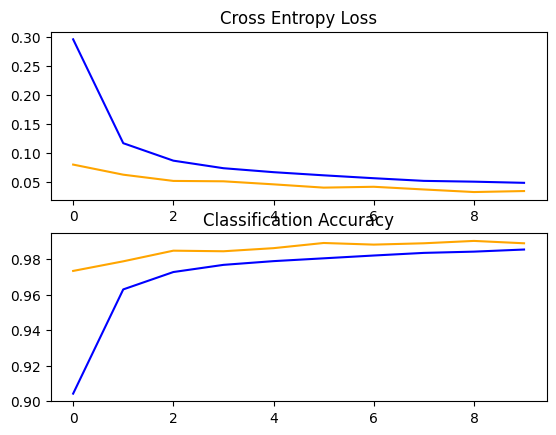

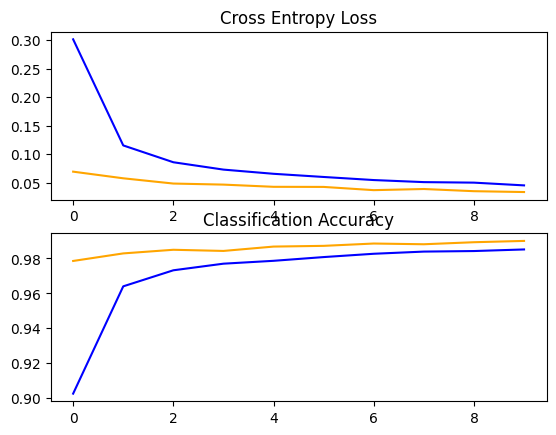

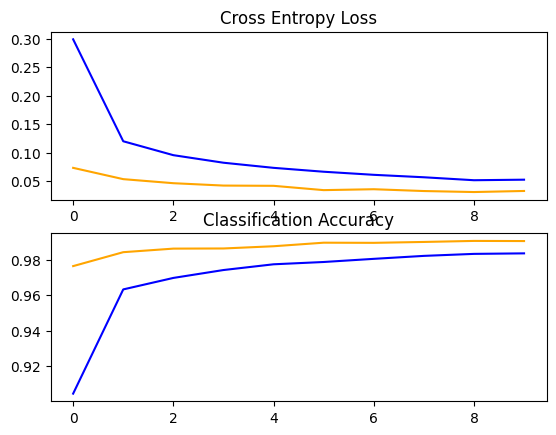

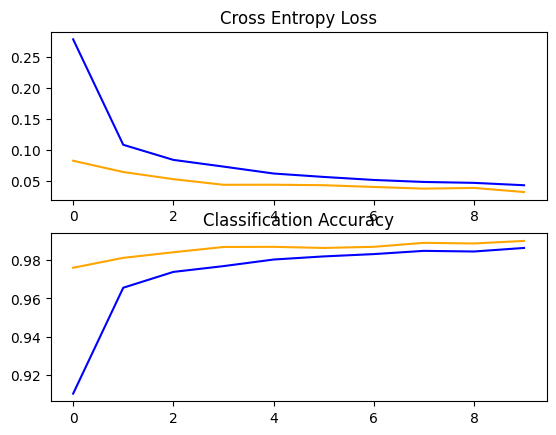

Accuracy: mean=98.995 std=0.050, n=5


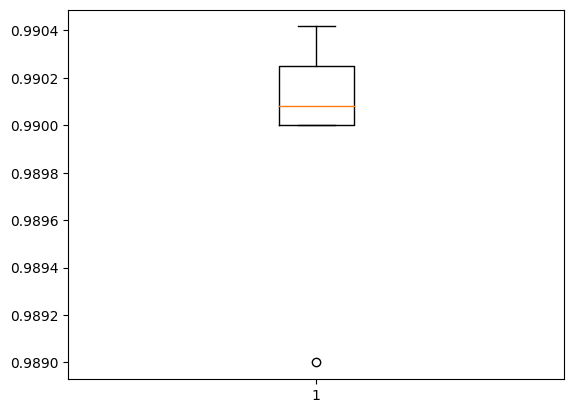

In [170]:
# entry point, run the test harness
run_test_harness()

## Save Final Model

In [171]:
# run the test harness for evaluating a model
def run_test_harness2():
  # load dataset
  trainX, trainY, testX, testY = load_dataset()

  # prepare pixel data
  trainX, testX = prep_pixels(trainX, testX)
  # define model
  model = define_model()

  # fit model
  model.fit(trainX, trainY, epochs=10, batch_size=32, verbose=1)

  # save model
  model.save('final_model.h5')
  _, acc = model.evaluate(testX, testY, verbose=0)
  print('Accuracy: %.3f' % (acc * 100.0))

## Evaluate Final Model

In [172]:
run_test_harness2()

Epoch 1/10
1875/1875 [==============================] - 11s 5ms/step - loss: 0.2540 - accuracy: 0.9194
Epoch 2/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1060 - accuracy: 0.9665
Epoch 3/10
1875/1875 [==============================] - 10s 6ms/step - loss: 0.0802 - accuracy: 0.9747
Epoch 4/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0705 - accuracy: 0.9778
Epoch 5/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0656 - accuracy: 0.9788
Epoch 6/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0566 - accuracy: 0.9819
Epoch 7/10
1875/1875 [==============================] - 10s 6ms/step - loss: 0.0523 - accuracy: 0.9831
Epoch 8/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0499 - accuracy: 0.9841
Epoch 9/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0475 - accuracy: 0.9847
Epoch 10/10
1875/1875 [==============================] - 10s 5ms/step - l

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Accuracy: 99.240


## Make Prediction

In [173]:
def load_image(filename):
  # load the image
  img = load_img(filename, grayscale=True, target_size=(50, 50))

  # convert to array
  img = img_to_array(img)

  # reshape into a single sample with 1 channel
  img = img.reshape(1, 50, 50, 1)

  # prepare pixel data
  img = img.astype('float32')
  img = img / 255.0

  return img

In [186]:
def reducing_noise(image):
  cross_kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (15,10))
  temp2 = 255 - cv2.morphologyEx(image, cv2.MORPH_CLOSE, cross_kernel)
  result = cv2.add(temp2, image)

  # Convert to grayscale and Otsu's threshold
  gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
  gray = cv2.GaussianBlur(gray,(5,5),0)
  _,thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
  return thresh

In [184]:
# load an image and predict the class
def run_example(test_img_dir, model):
  # load the image
  img = cv2.imread(test_img_dir)
  img = cv2.resize(img, (50,50))
  plt.imshow(img)
  plt.show()
  # Reducing Noise
  res = reducing_noise(img)
  img = res.astype('float32')
  img /= 255.0
  img = img.reshape(1, 50, 50, 1)

  # predict the class
  predict_value = model.predict(img, verbose = 0)

  digit = argmax(predict_value)
  return digit

----------------------------------------------------------------------------------
Label: 9


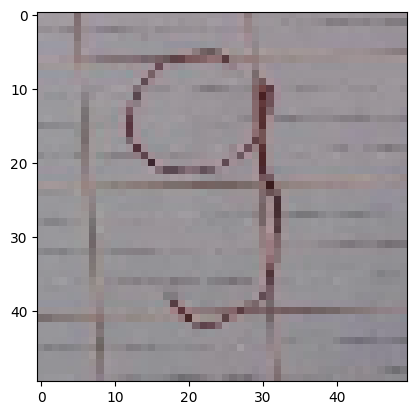

Predict: 9
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 9


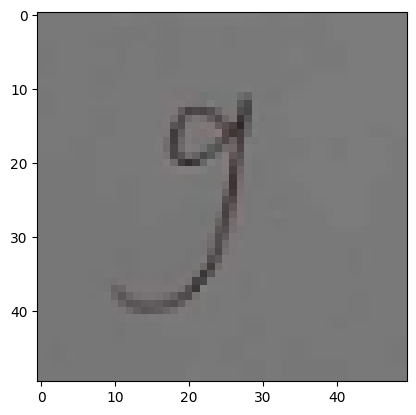

Predict: 3
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 9


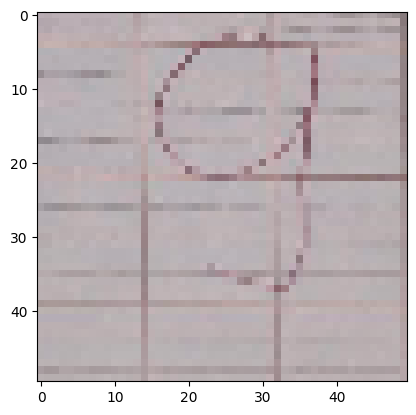

Predict: 5
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 9


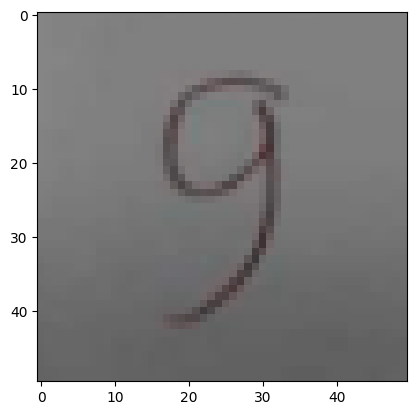

Predict: 9
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 9


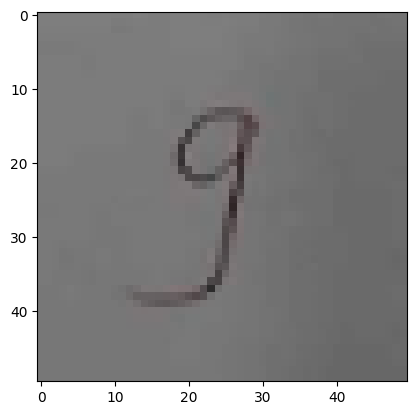

Predict: 9
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 9


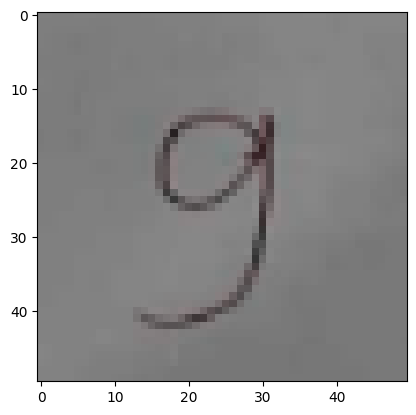

Predict: 9
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 9


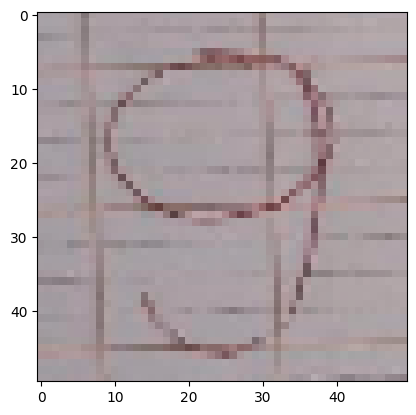

Predict: 9
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 9


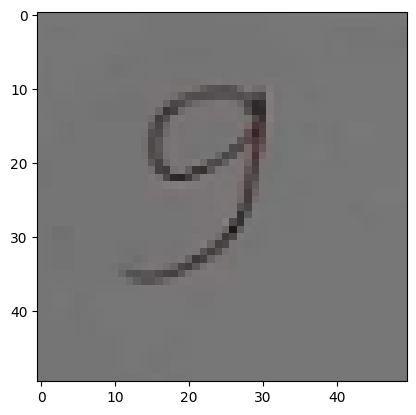

Predict: 9
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 9


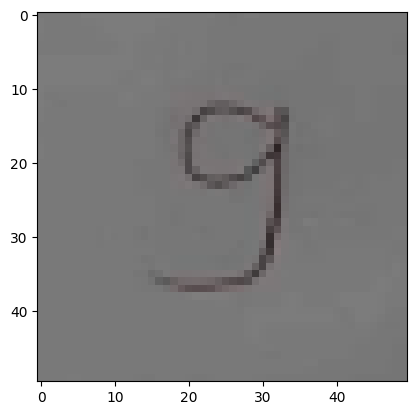

Predict: 9
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 8


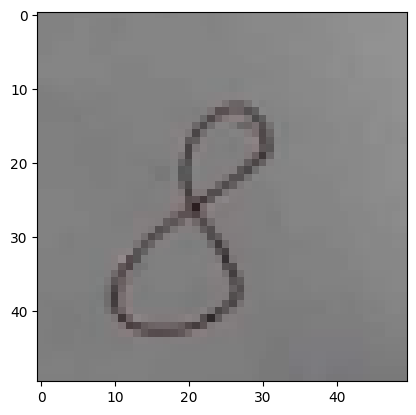

Predict: 8
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 8


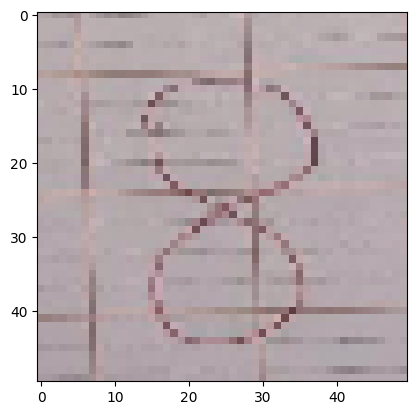

Predict: 8
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 8


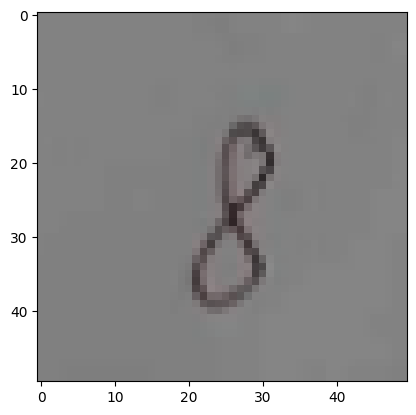

Predict: 8
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 8


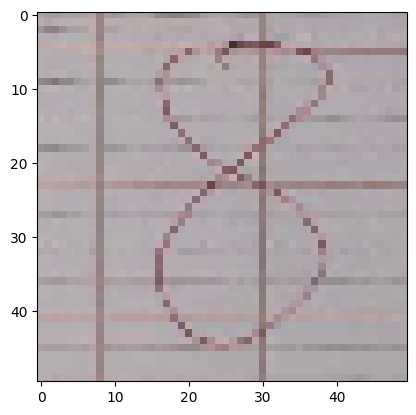

Predict: 8
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 8


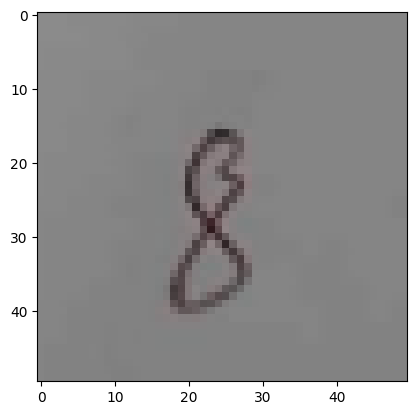

Predict: 8
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 8


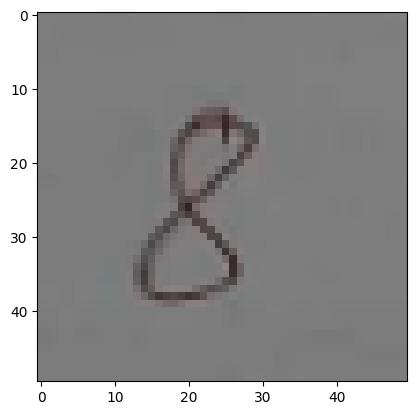

Predict: 8
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 8


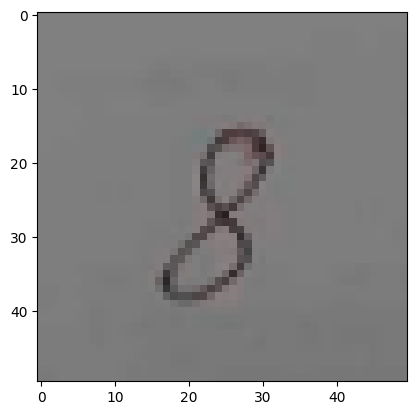

Predict: 8
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 8


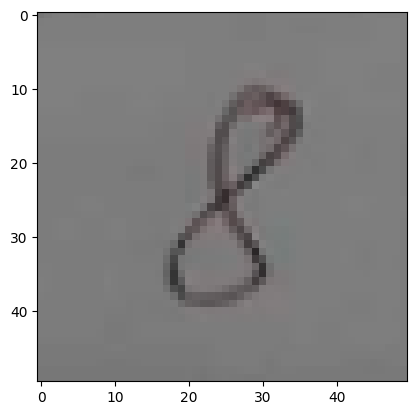

Predict: 8
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 8


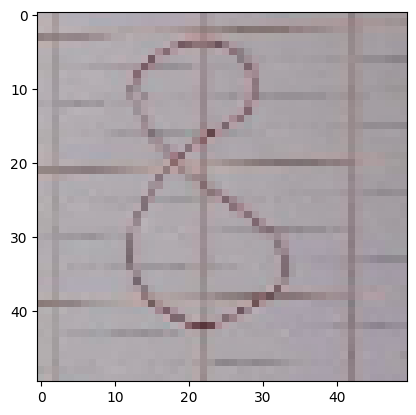

Predict: 8
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 7


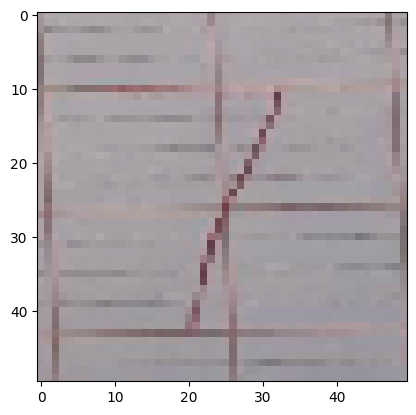

Predict: 7
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 7


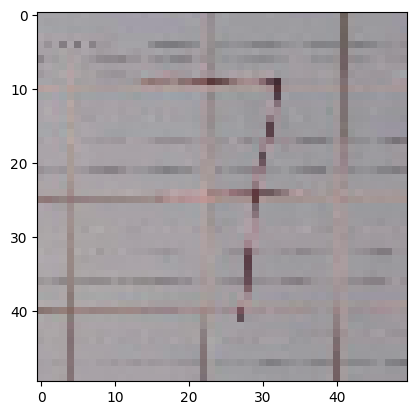

Predict: 3
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 7


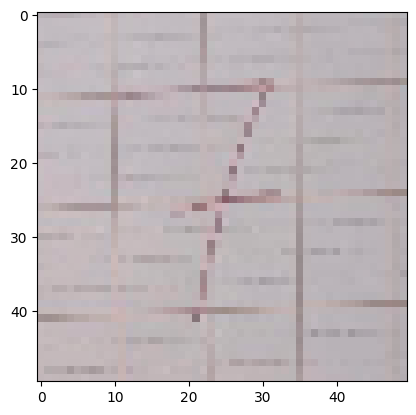

Predict: 5
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 7


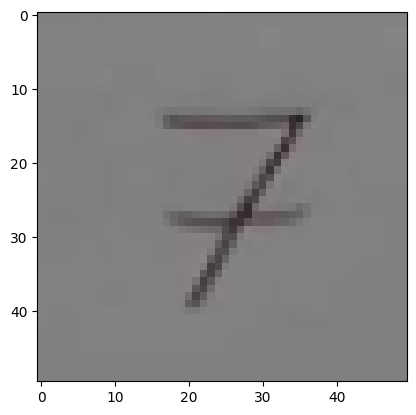

Predict: 7
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 7


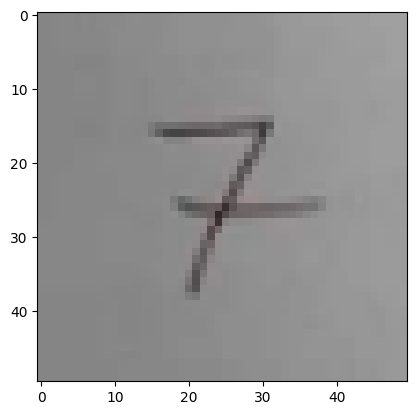

Predict: 7
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 7


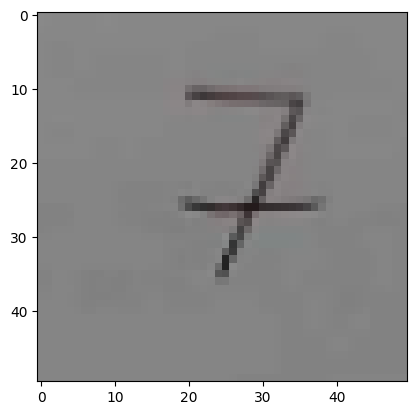

Predict: 7
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 7


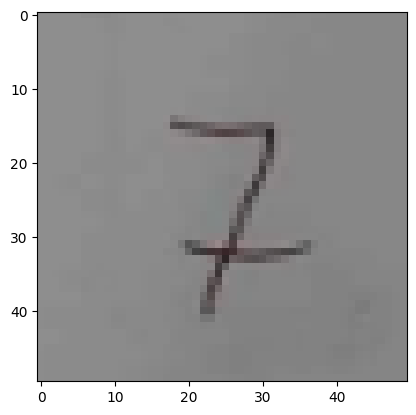

Predict: 7
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 7


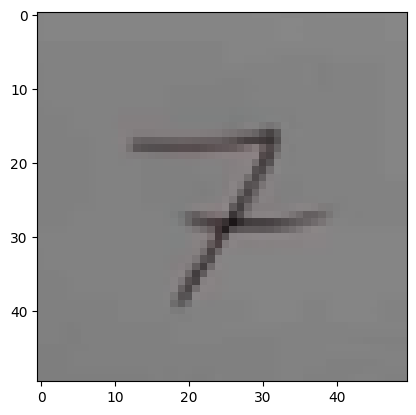

Predict: 7
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 7


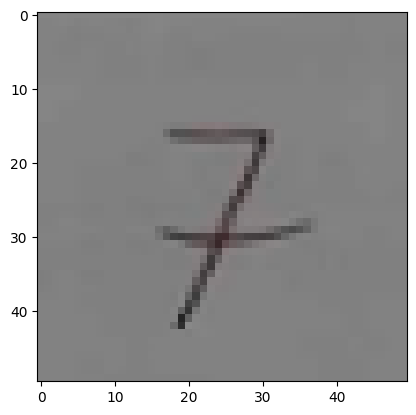

Predict: 7
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 6


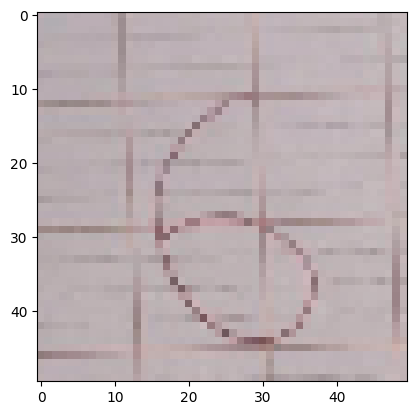

Predict: 5
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 6


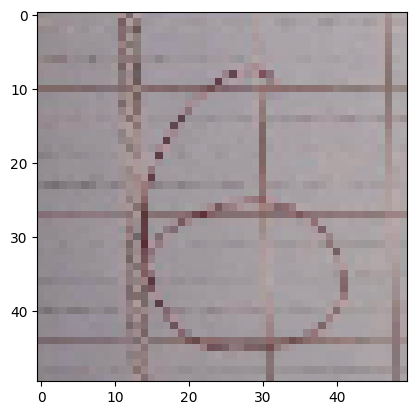

Predict: 8
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 6


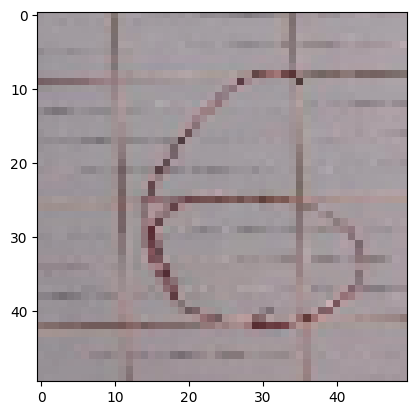

Predict: 6
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 6


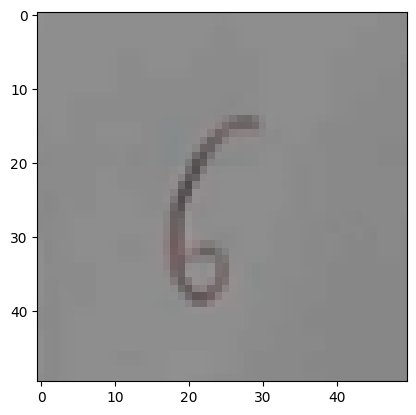

Predict: 6
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 6


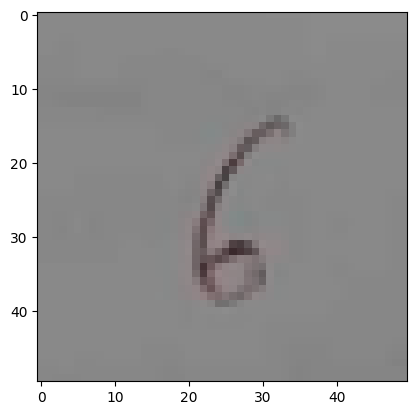

Predict: 6
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 6


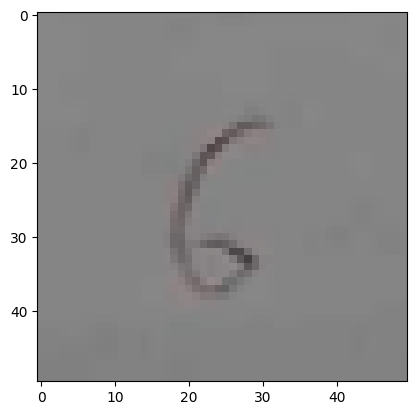

Predict: 6
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 6


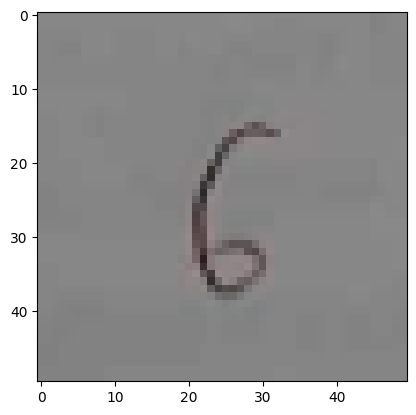

Predict: 6
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 6


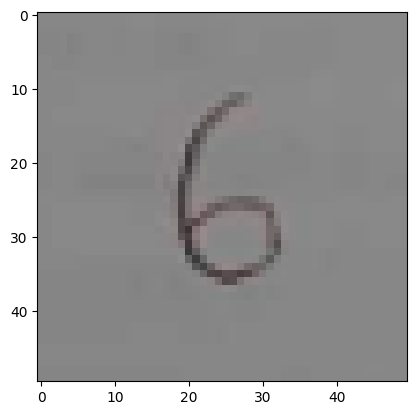

Predict: 6
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 6


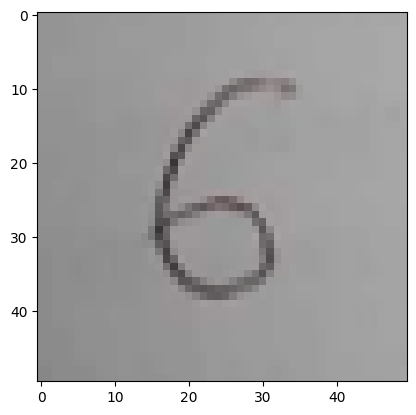

Predict: 6
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 5


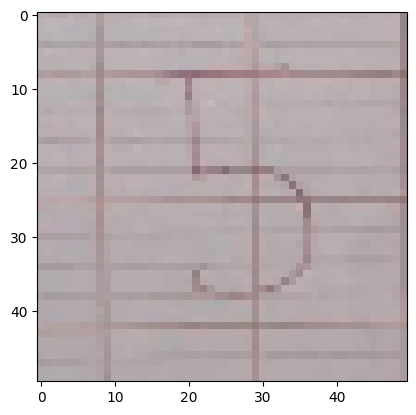

Predict: 5
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 5


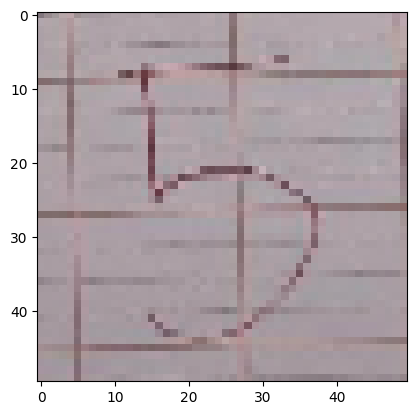

Predict: 5
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 5


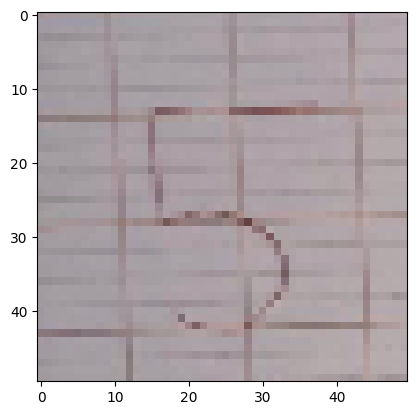

Predict: 5
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 5


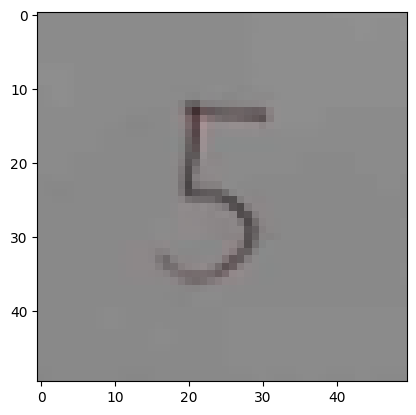

Predict: 5
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 5


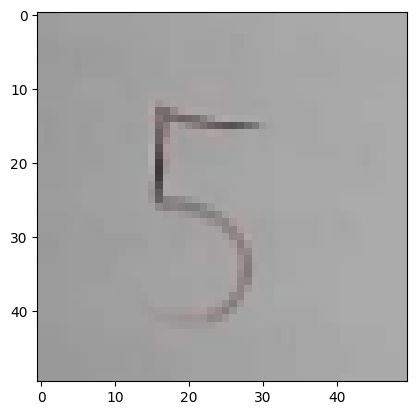

Predict: 5
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 5


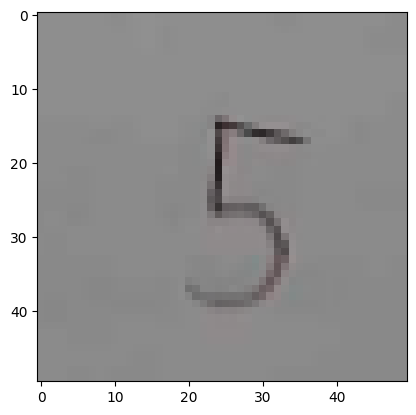

Predict: 5
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 5


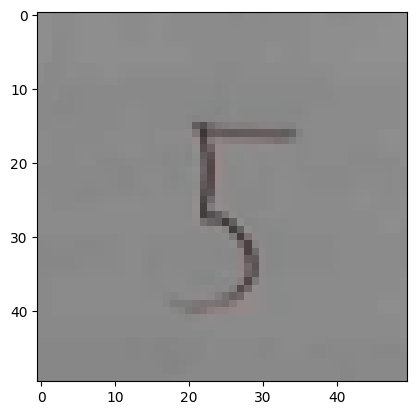

Predict: 5
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 5


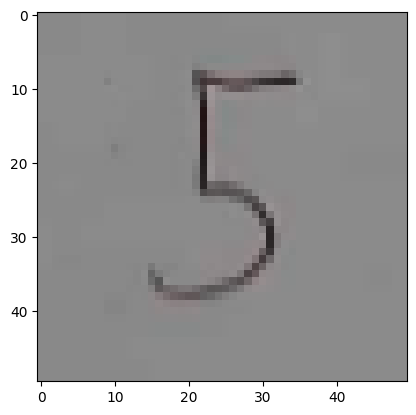

Predict: 5
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 5


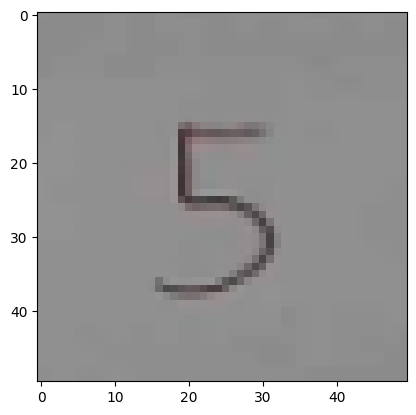

Predict: 5
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 4


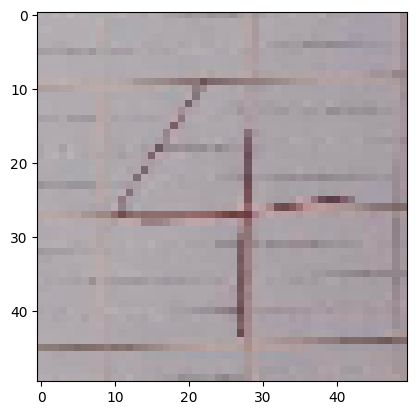

Predict: 4
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 4


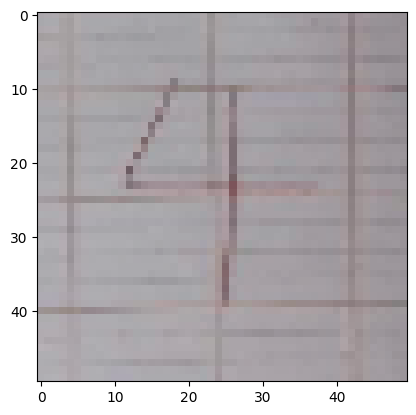

Predict: 1
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 4


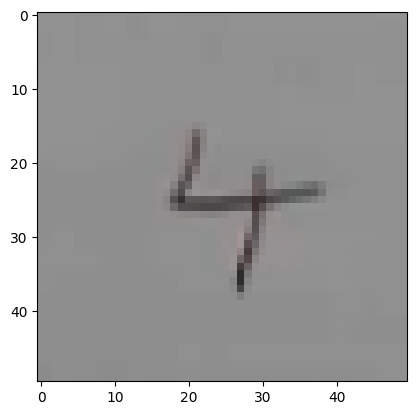

Predict: 4
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 4


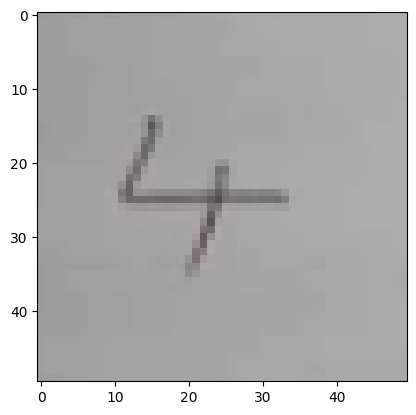

Predict: 4
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 4


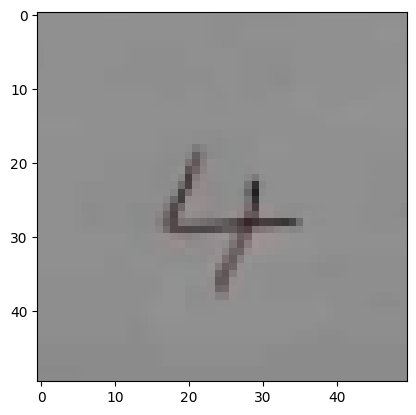

Predict: 4
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 4


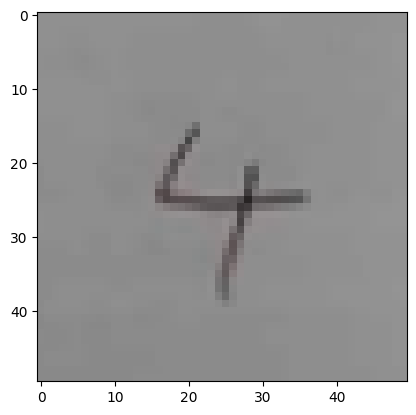

Predict: 4
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 4


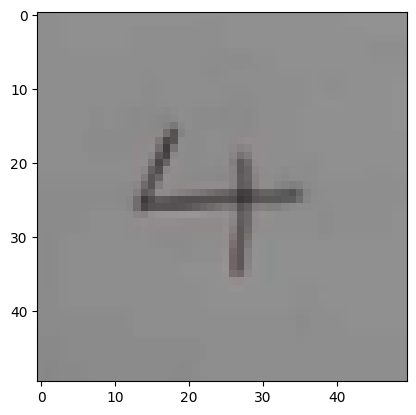

Predict: 4
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 4


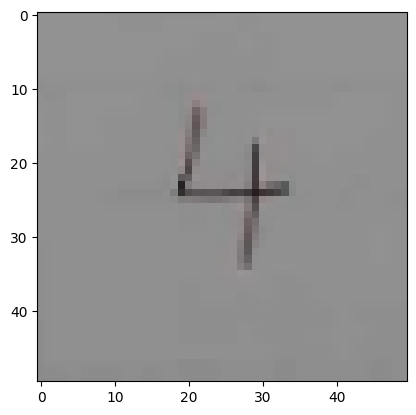

Predict: 4
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 4


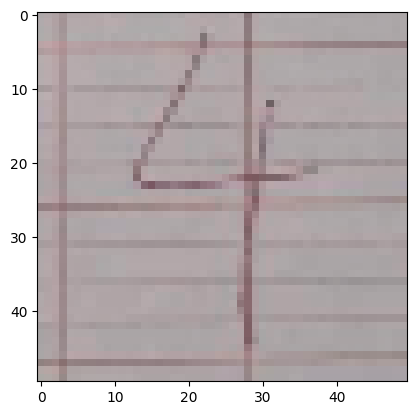

Predict: 4
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 3


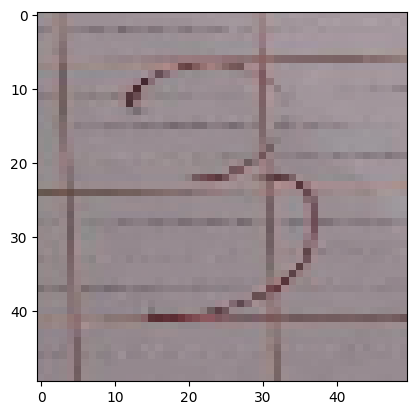

Predict: 3
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 3


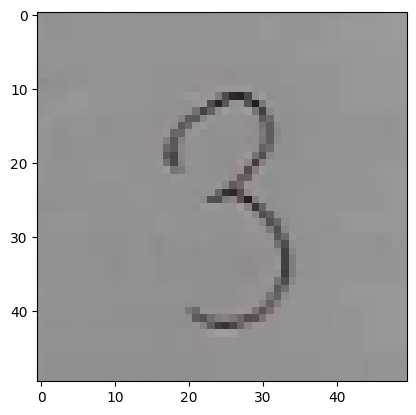

Predict: 3
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 3


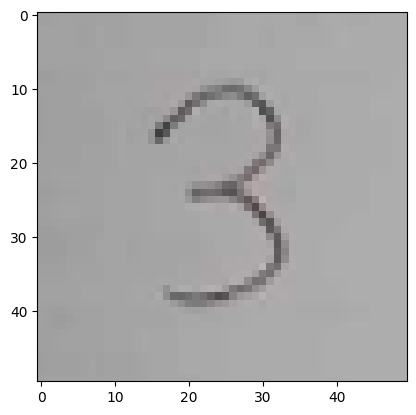

Predict: 3
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 3


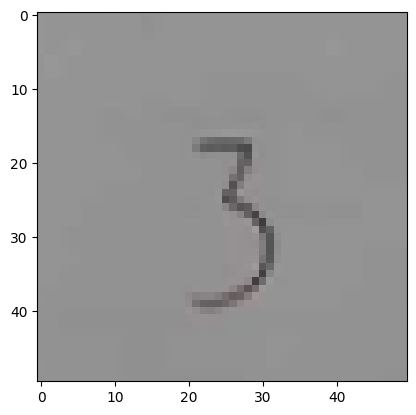

Predict: 3
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 3


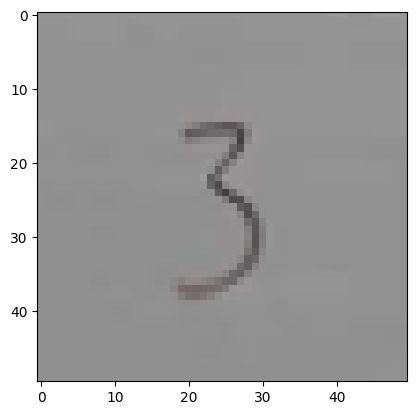

Predict: 3
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 3


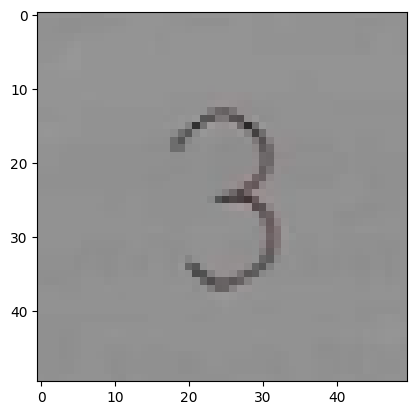

Predict: 3
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 3


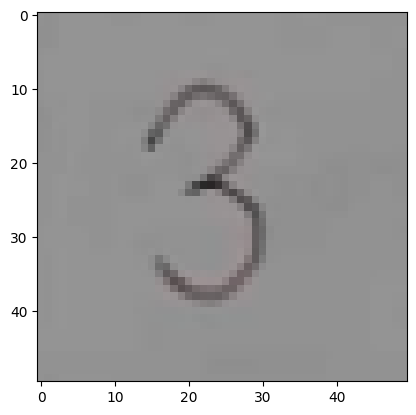

Predict: 3
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 3


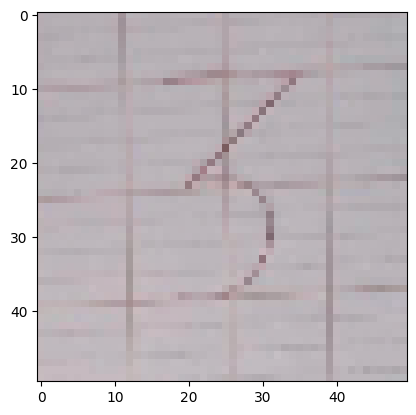

Predict: 3
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 3


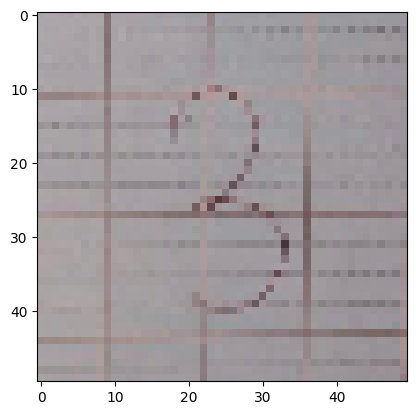

Predict: 3
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 2


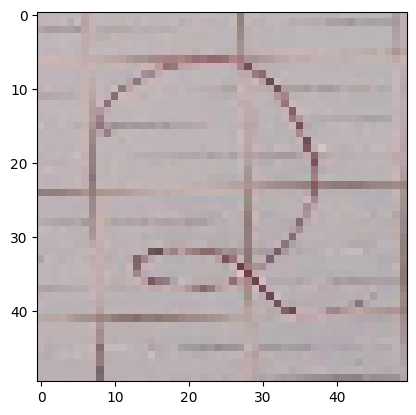

Predict: 2
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 2


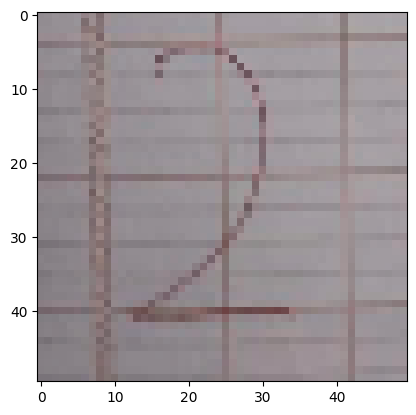

Predict: 2
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 2


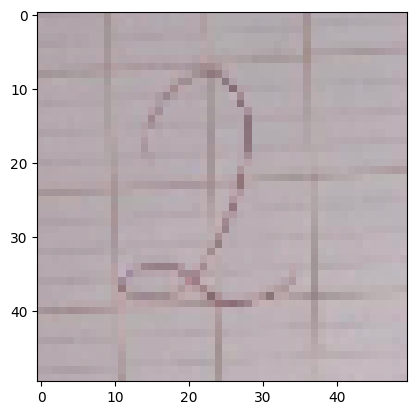

Predict: 2
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 2


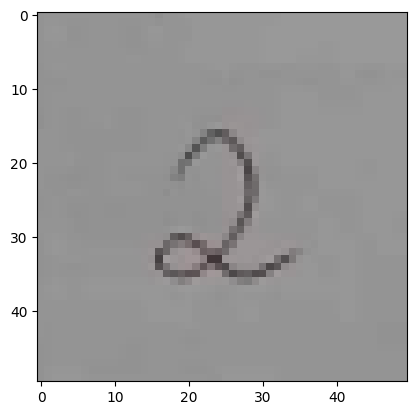

Predict: 2
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 2


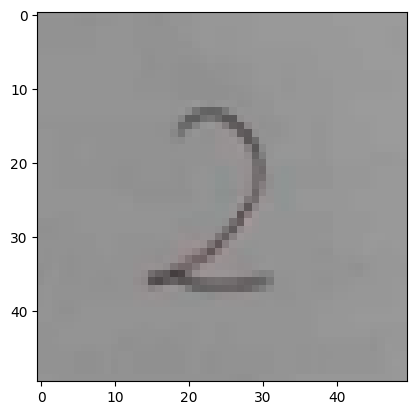

Predict: 2
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 2


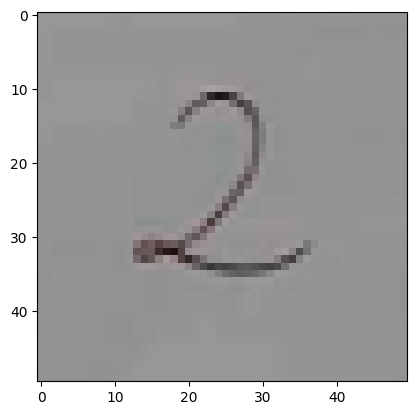

Predict: 2
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 2


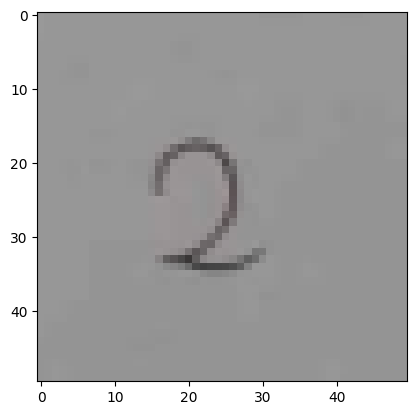

Predict: 2
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 2


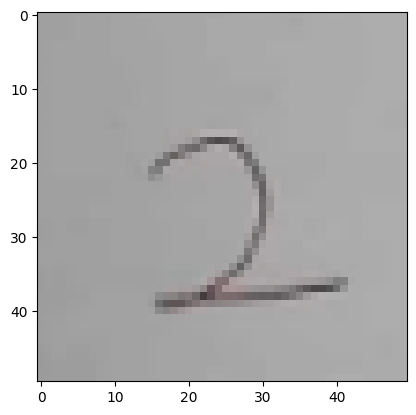

Predict: 2
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 2


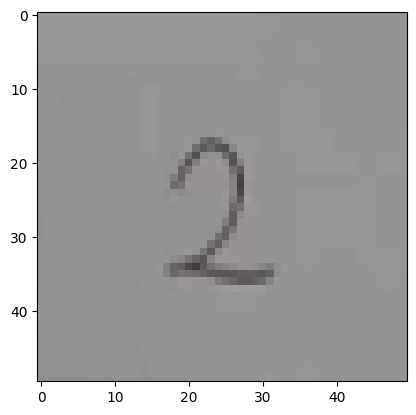

Predict: 2
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 1


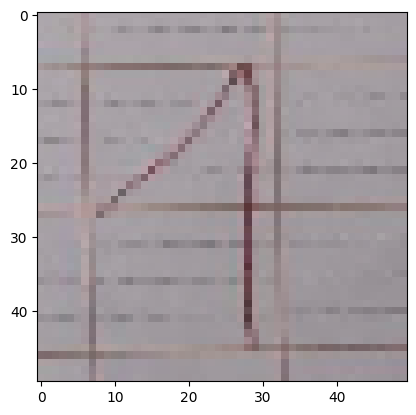

Predict: 4
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 1


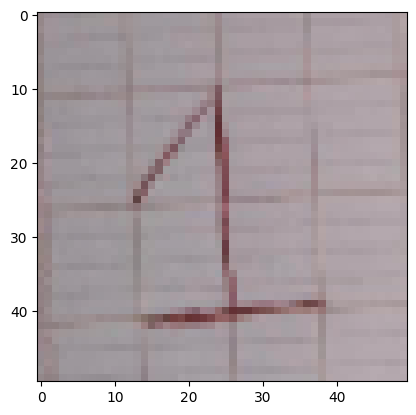

Predict: 1
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 1


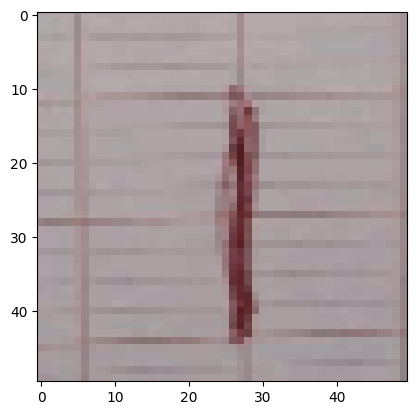

Predict: 1
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 1


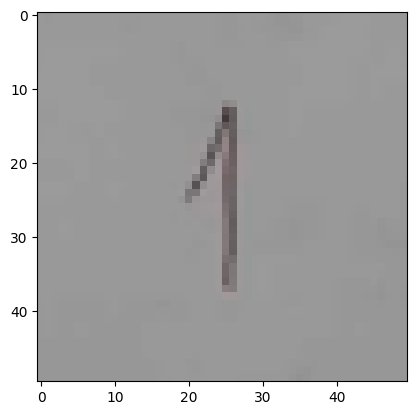

Predict: 1
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 1


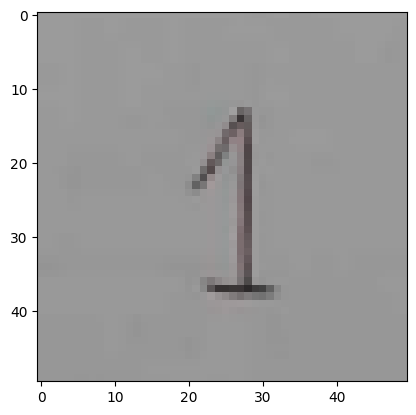

Predict: 1
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 1


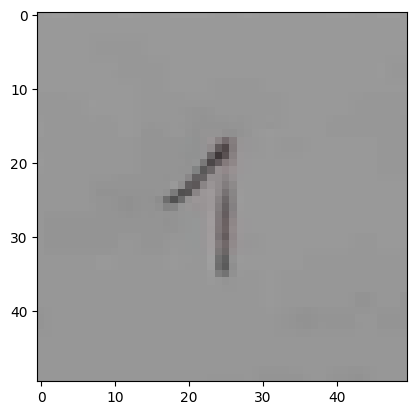

Predict: 1
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 1


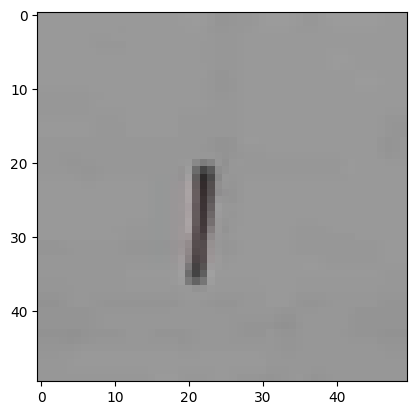

Predict: 5
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 1


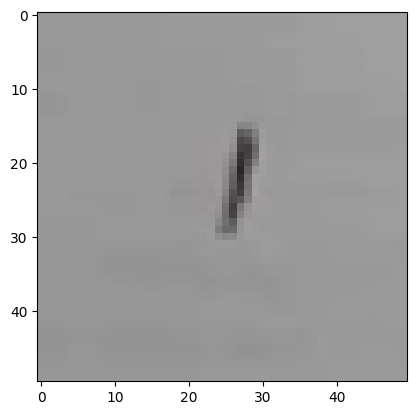

Predict: 1
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 1


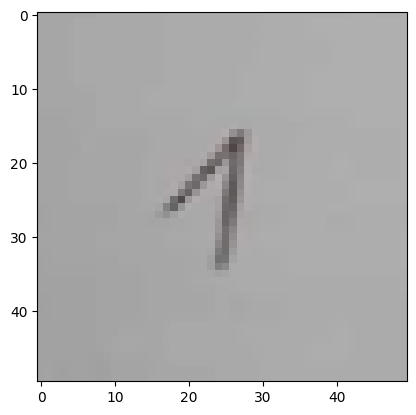

Predict: 1
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 0


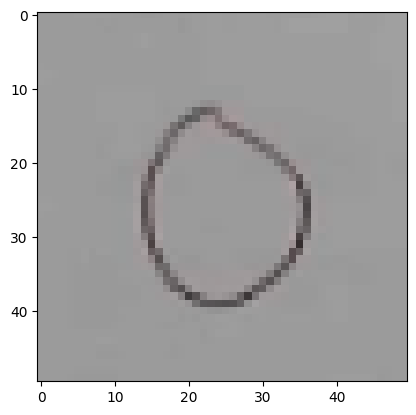

Predict: 0
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 0


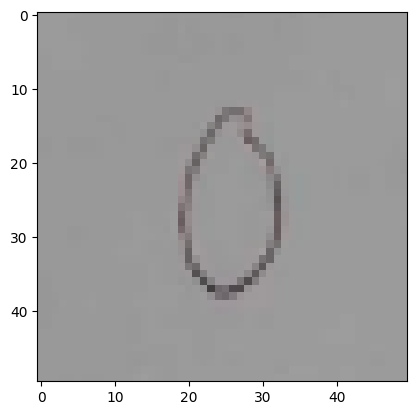

Predict: 0
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 0


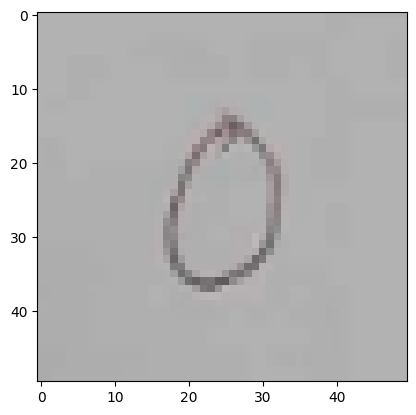

Predict: 0
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 0


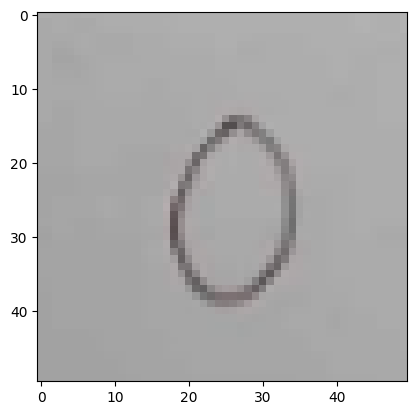

Predict: 0
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 0


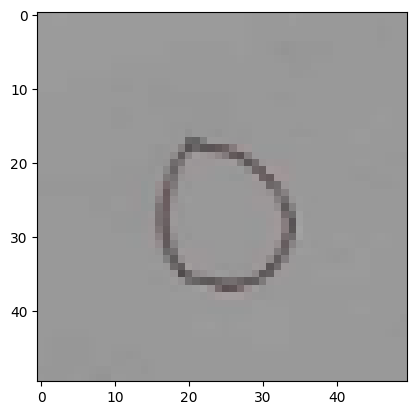

Predict: 0
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 0


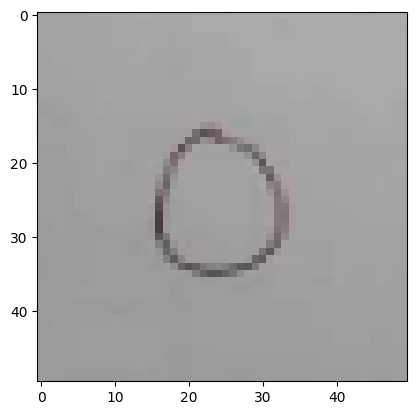

Predict: 0
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 0


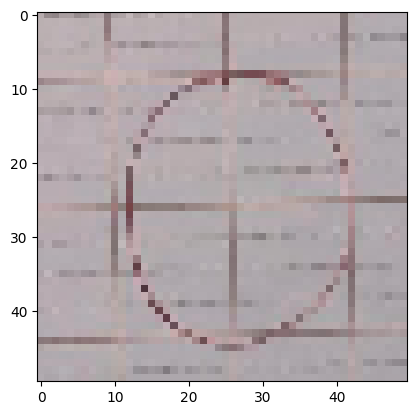

Predict: 0
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 0


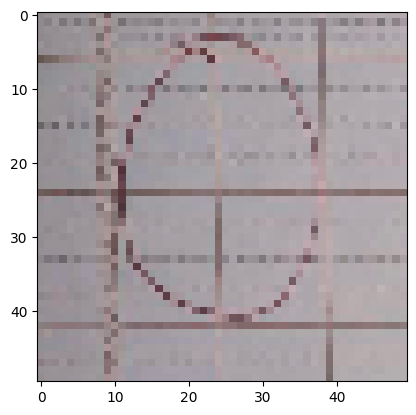

Predict: 5
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Label: 0


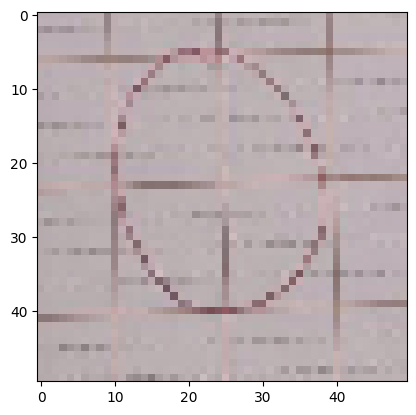

Predict: 5
----------------------------------------------------------------------------------
Wrong Predicted:  11
Accuracy: 87.778


In [187]:
# entry point, run the example
# load model
model = load_model('final_model.h5')
img_list_dir = '/content/drive/MyDrive/Máy Học/Lab01/Dataset/'
count = 0
correct_count = 0
for i in os.listdir(img_list_dir):
  for j in os.listdir(img_list_dir+i):
    print('----------------------------------------------------------------------------------')
    print('Label:',i)
    digit = run_example(img_list_dir+i+'/'+j, model)
    print('Predict:',digit)
    print('----------------------------------------------------------------------------------')
    if(int(digit) == int(i)):
      correct_count += 1
    count += 1
print('Wrong Predicted: ', count - correct_count)
print('Accuracy: %.3f' % ((correct_count/count)*100))